# Импорты

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve, auc)
from sklearn.inspection import permutation_importance
from sklearn.multiclass import OneVsRestClassifier
import warnings
warnings.filterwarnings('ignore')

# Выбор и загрузка данных

In [67]:
df = pd.read_csv('f1_dataset.csv')

# Изучение структуры данных

In [68]:
print(f"Размер датасета: {df.shape}")
print(df.info())
print(df.describe())
print(f"--- Типы данных ---\n{df.dtypes}")
print(f"--- Первые 5 записей ---\n{df.head(5)}")
print(f"--- Последние 5 записей --- \n{df.tail(5)}")

Размер датасета: (1142, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142 entries, 0 to 1141
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1142 non-null   object 
 1   continent    1142 non-null   object 
 2   grand_prix   1142 non-null   object 
 3   circuit      1142 non-null   object 
 4   winner_name  1142 non-null   object 
 5   team         1142 non-null   object 
 6   time         1142 non-null   object 
 7   laps         1142 non-null   float64
 8   year         1142 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 80.4+ KB
None
              laps         year
count  1142.000000  1142.000000
mean     64.617338  1992.999124
std      20.065139    20.850097
min       1.000000  1950.000000
25%      54.000000  1977.000000
50%      64.000000  1995.000000
75%      72.000000  2011.000000
max     200.000000  2025.000000
--- Типы данных ---
date            object
contin

# Предобработка данных

## Проверка на наличие пропущенных значений

In [69]:
print(df.isnull().sum())

date           0
continent      0
grand_prix     0
circuit        0
winner_name    0
team           0
time           0
laps           0
year           0
dtype: int64


Исходя из отсутствия пропущенных значений, пропустим этот шаг

## Проверка на наличие дубликатов

In [70]:
print("Количество дубликатов:", df.duplicated().sum())

Количество дубликатов: 0


Исходя из отсутствия дубликатов, пропустим этот шаг

## Анализ выбросов

In [71]:
num_cols = df.select_dtypes(include=[np.number]).columns

Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

mask = ~((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
print("Удалено выбросов:", (~mask).sum())

df = df[mask]


Удалено выбросов: 65


## Преобразование типов данных

In [72]:
df['date'] = pd.to_datetime(df['date'])

def time_to_seconds(t):
    if str(t).count(':') == 2:
        h, m, s = map(int, str(t).split(':'))
        return h * 3600 + m * 60 + s
    elif str(t).count(':') == 1:
        m, s = map(int, str(t).split(':'))
        return m * 60 + s
    return np.nan

df['time_seconds'] = df['time'].apply(time_to_seconds)

print("Типы данных после преобразования:")
print(df[['date', 'time_seconds']].dtypes)
df[['date', 'time', 'time_seconds']].head()

Типы данных после преобразования:
date            datetime64[ns]
time_seconds             int64
dtype: object


,date,time,time_seconds
0,1950-05-13,02:13:23,8003
3,1950-06-04,02:02:53,7373
4,1950-06-18,02:47:26,10046
5,1950-07-02,02:57:52,10672
6,1950-09-03,02:51:17,10277


## Создание новых переменных

Была создана переменная ```decade``` для анализа трендов в различных эпохи Формулы-1




In [73]:
df['decade'] = (df['year'] // 10) * 10
df[['year', 'decade']].head(10)

,year,decade
0,1950,1950
3,1950,1950
4,1950,1950
5,1950,1950
6,1950,1950
7,1951,1950
9,1951,1950
10,1951,1950
11,1951,1950
12,1951,1950


# Предобработка признаков для классификации

In [74]:
# Кодирование категориальных признаков (continent будет целевой переменной)
df = pd.get_dummies(df, columns=['grand_prix', 'circuit', 'team', 'winner_name'], drop_first=True)

# Создание дополнительных числовых признаков
df['year_log'] = np.log1p(df['year'])
df['laps_log'] = np.log1p(df['laps'])
df['laps_per_year'] = df['laps'] / df['year']
df['time_seconds_log'] = np.log1p(df['time_seconds'])

# Проверка распределения целевой переменной
print("Распределение классов (continent):")
print(df['continent'].value_counts())
print(f"\nКоличество классов: {df['continent'].nunique()}")

Распределение классов (continent):
continent
Europe           644
Asia             163
North America    137
South America     71
Oceania           38
Africa            24
Name: count, dtype: int64

Количество классов: 6


# Разделение данных на признаки и целевую переменную

In [75]:
X = df.drop(columns=['time', 'date', 'time_seconds', 'continent'])
y = df['continent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts())
print(f"\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts())

Размер обучающей выборки: (861, 276)
Размер тестовой выборки: (216, 276)

Распределение классов в обучающей выборке:
continent
Europe           515
Asia             130
North America    110
South America     57
Oceania           30
Africa            19
Name: count, dtype: int64

Распределение классов в тестовой выборке:
continent
Europe           129
Asia              33
North America     27
South America     14
Oceania            8
Africa             5
Name: count, dtype: int64


# Функция оценки моделей классификации

In [76]:
def eval_model(m, Xtr, ytr, Xte, yte, name):

    m.fit(Xtr, ytr)
    yp_tr = m.predict(Xtr)
    yp_te = m.predict(Xte)

    accuracy = accuracy_score(yte, yp_te)
    precision = precision_score(yte, yp_te, average='weighted', zero_division=0)
    recall = recall_score(yte, yp_te, average='weighted', zero_division=0)
    f1 = f1_score(yte, yp_te, average='weighted', zero_division=0)

    try:
        if hasattr(m, 'predict_proba'):
            y_proba = m.predict_proba(Xte)
            roc_auc = roc_auc_score(yte, y_proba, multi_class='ovr', average='weighted')
        else:
            roc_auc = np.nan
    except:
        roc_auc = np.nan

    return {
        'model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC-AUC': roc_auc
    }, yp_te, m

results = []
predictions = {}
models_dict = {}

# Обучение моделей классификации

## 1. Дерево решений (DecisionTreeClassifier)

In [77]:
dt = DecisionTreeClassifier(random_state=42, max_depth=10)
res_dict, y_pred_dt, model_dt = eval_model(dt, X_train_scaled, y_train, X_test_scaled, y_test, 'DecisionTree')
results.append(res_dict)
predictions['DecisionTree'] = y_pred_dt
models_dict['DecisionTree'] = model_dt
print(f"DecisionTree обучена. Accuracy: {res_dict['Accuracy']:.4f}")

DecisionTree обучена. Accuracy: 0.9861


## 2. k ближайших соседей (KNeighborsClassifier)

In [78]:
knn = KNeighborsClassifier(n_neighbors=5)
res_dict, y_pred_knn, model_knn = eval_model(knn, X_train_scaled, y_train, X_test_scaled, y_test, 'KNN')
results.append(res_dict)
predictions['KNN'] = y_pred_knn
models_dict['KNN'] = model_knn
print(f"KNN обучена. Accuracy: {res_dict['Accuracy']:.4f}")


KNN обучена. Accuracy: 0.8889


## 3. Логистическая регрессия (LogisticRegression)

In [79]:
lr = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
res_dict, y_pred_lr, model_lr = eval_model(lr, X_train_scaled, y_train, X_test_scaled, y_test, 'LogisticRegression')
results.append(res_dict)
predictions['LogisticRegression'] = y_pred_lr
models_dict['LogisticRegression'] = model_lr
print(f"LogisticRegression обучена. Accuracy: {res_dict['Accuracy']:.4f}")

LogisticRegression обучена. Accuracy: 0.9861


## 4. Наивный байесовский классификатор (GaussianNB)

In [80]:
nb = GaussianNB()
res_dict, y_pred_nb, model_nb = eval_model(nb, X_train_scaled, y_train, X_test_scaled, y_test, 'GaussianNB')
results.append(res_dict)
predictions['GaussianNB'] = y_pred_nb
models_dict['GaussianNB'] = model_nb
print(f"GaussianNB обучена. Accuracy: {res_dict['Accuracy']:.4f}")

GaussianNB обучена. Accuracy: 0.9074


# Сравнительная таблица результатов всех моделей

In [81]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

display(results_df.round(4))

,model,Accuracy,Precision,Recall,F1,ROC-AUC
0,DecisionTree,0.9861,0.9860,0.9861,0.9860,0.9900
1,LogisticRegression,0.9861,0.9864,0.9861,0.9859,1.0000
2,GaussianNB,0.9074,0.9109,0.9074,0.9070,0.9356
3,KNN,0.8889,0.8973,0.8889,0.8845,0.9710


# Confusion Matrix для каждой модели

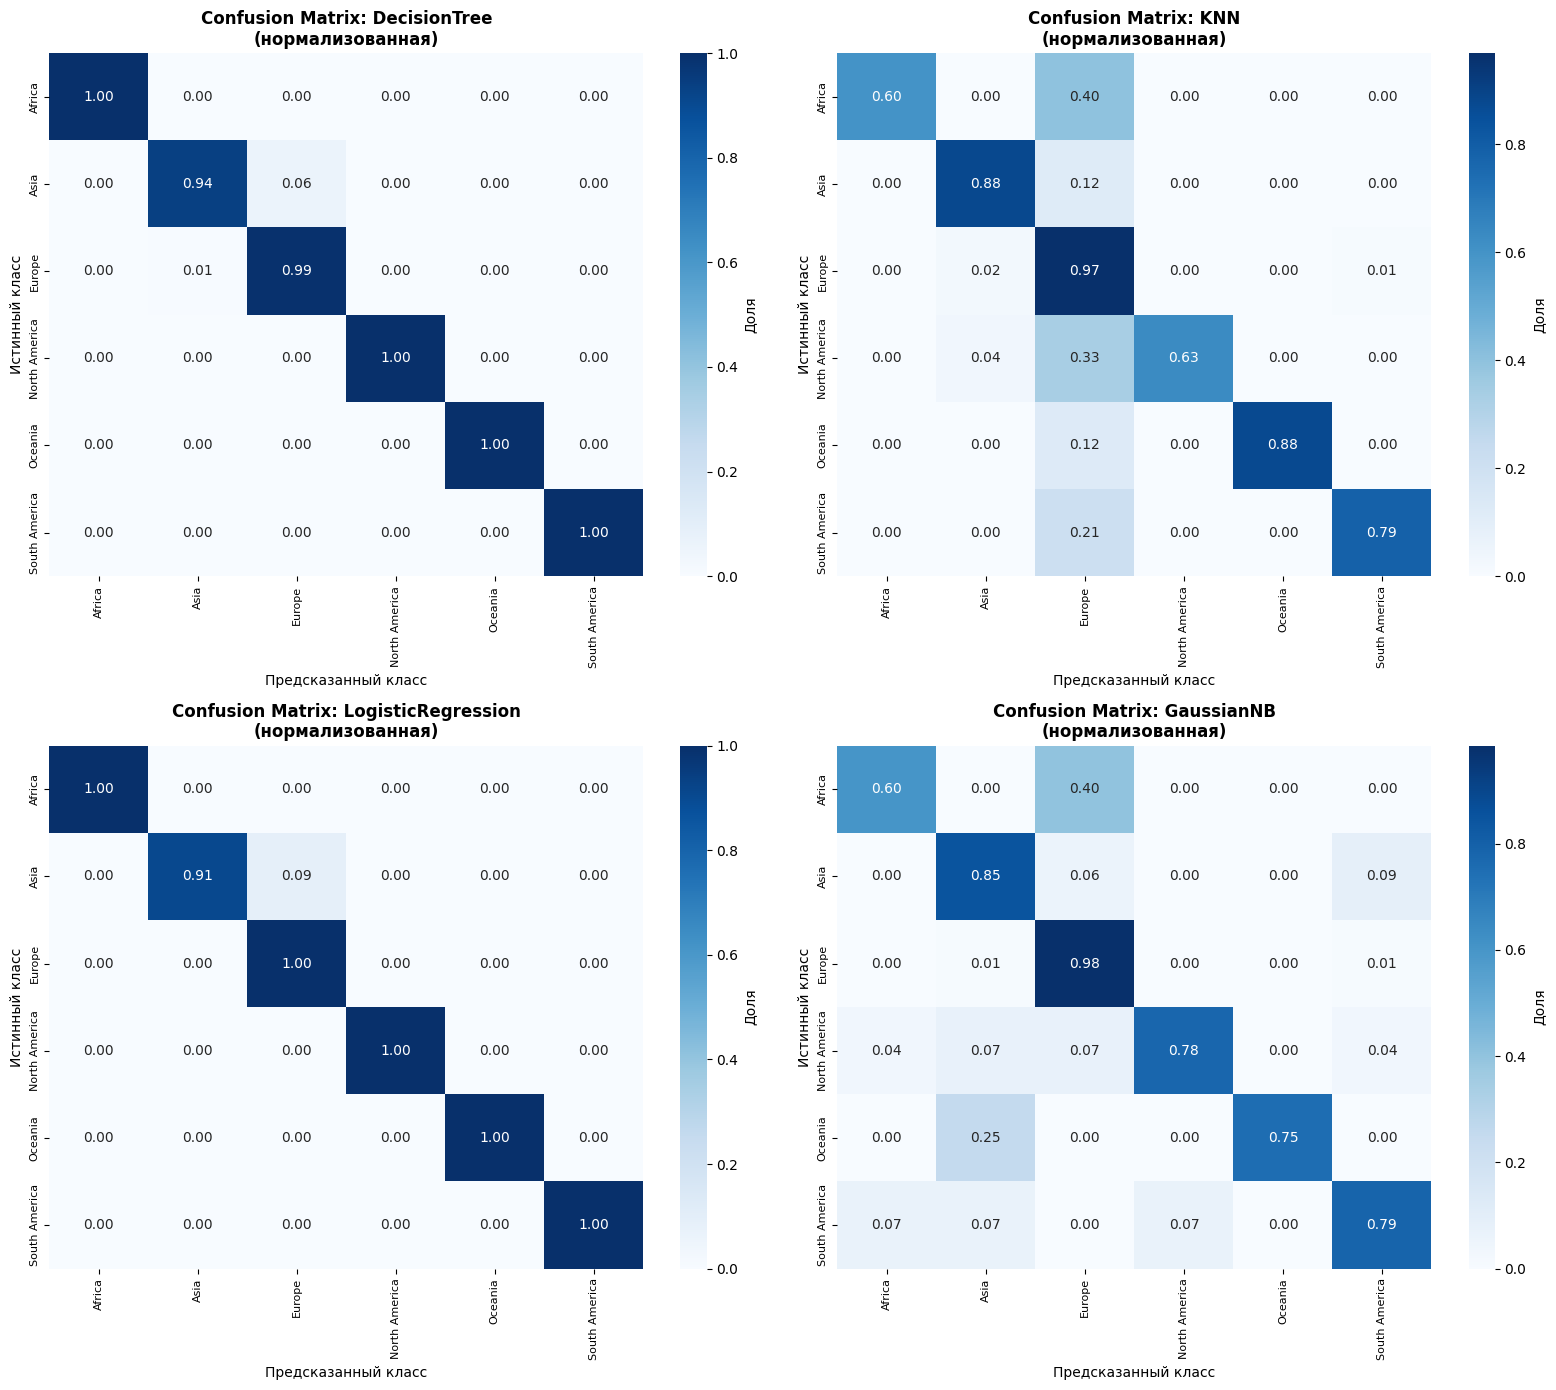


DecisionTree:
               Africa  Asia  Europe  North America  Oceania  South America
Africa              5     0       0              0        0              0
Asia                0    31       2              0        0              0
Europe              0     1     128              0        0              0
North America       0     0       0             27        0              0
Oceania             0     0       0              0        8              0
South America       0     0       0              0        0             14

KNN:
               Africa  Asia  Europe  North America  Oceania  South America
Africa              3     0       2              0        0              0
Asia                0    29       4              0        0              0
Europe              0     3     125              0        0              1
North America       0     1       9             17        0              0
Oceania             0     0       1              0        7              0
Sout

In [82]:
classes = sorted(y_test.unique())

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, (model_name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred, labels=classes)

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes, ax=axes[idx],
                cbar_kws={'label': 'Доля'})
    axes[idx].set_title(f'Confusion Matrix: {model_name}\n(нормализованная)',
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Предсказанный класс', fontsize=10)
    axes[idx].set_ylabel('Истинный класс', fontsize=10)
    axes[idx].tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()

for model_name, y_pred in predictions.items():
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    print(f"\n{model_name}:")
    print(pd.DataFrame(cm, index=classes, columns=classes))

# Детальный отчет по классификации для лучшей модели

In [ ]:
best_model_name = results_df.iloc[0]['model']
best_model = models_dict[best_model_name]
y_pred_best = predictions[best_model_name]

print(classification_report(y_test, y_pred_best, target_names=classes))

               precision    recall  f1-score   support

       Africa       1.00      1.00      1.00         5
         Asia       0.97      0.94      0.95        33
       Europe       0.98      0.99      0.99       129
North America       1.00      1.00      1.00        27
      Oceania       1.00      1.00      1.00         8
South America       1.00      1.00      1.00        14

     accuracy                           0.99       216
    macro avg       0.99      0.99      0.99       216
 weighted avg       0.99      0.99      0.99       216



# Визуализация метрик для всех моделей

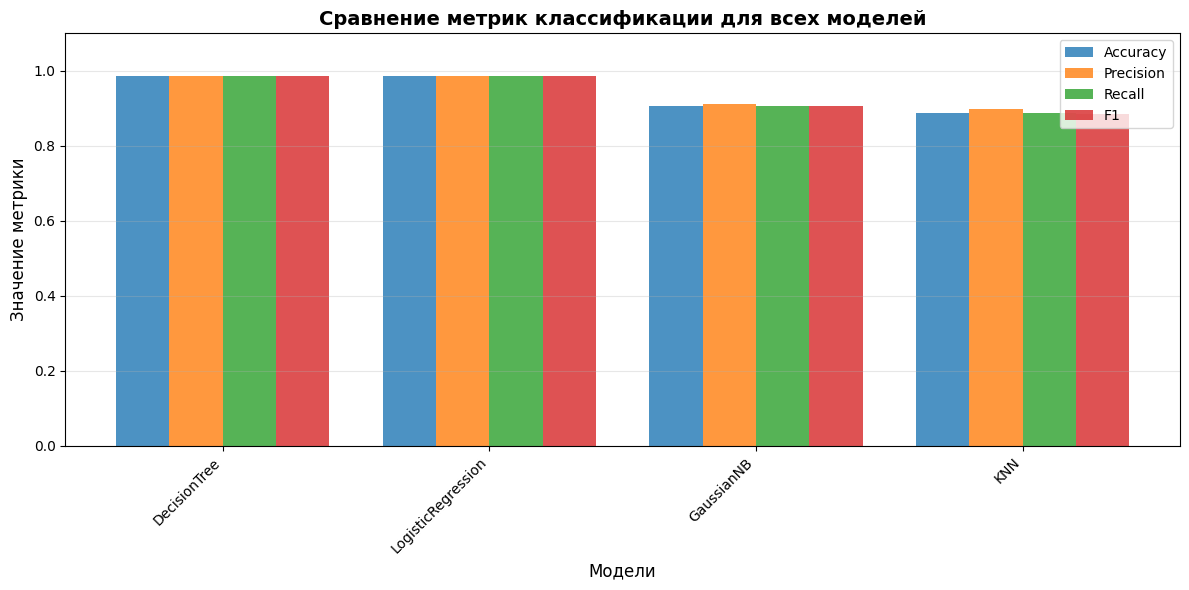

,model,ROC-AUC
0,DecisionTree,0.9900
1,LogisticRegression,1.0000
2,GaussianNB,0.9356
3,KNN,0.9710


In [ ]:
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1']
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    offset = (i - len(metrics_to_plot)/2) * width + width/2
    ax.bar(x + offset, results_df[metric], width, label=metric, alpha=0.8)

ax.set_xlabel('Модели', fontsize=12)
ax.set_ylabel('Значение метрики', fontsize=12)
ax.set_title('Сравнение метрик классификации для всех моделей', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['model'], rotation=45, ha='right')
ax.legend(loc='best')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

roc_auc_df = results_df[['model', 'ROC-AUC']].copy()
roc_auc_df = roc_auc_df.dropna()
if len(roc_auc_df) > 0:
    display(roc_auc_df.round(4))
else:
    print("\nROC-AUC метрики недоступны для всех моделей.")

# ROC-кривые для моделей с вероятностями

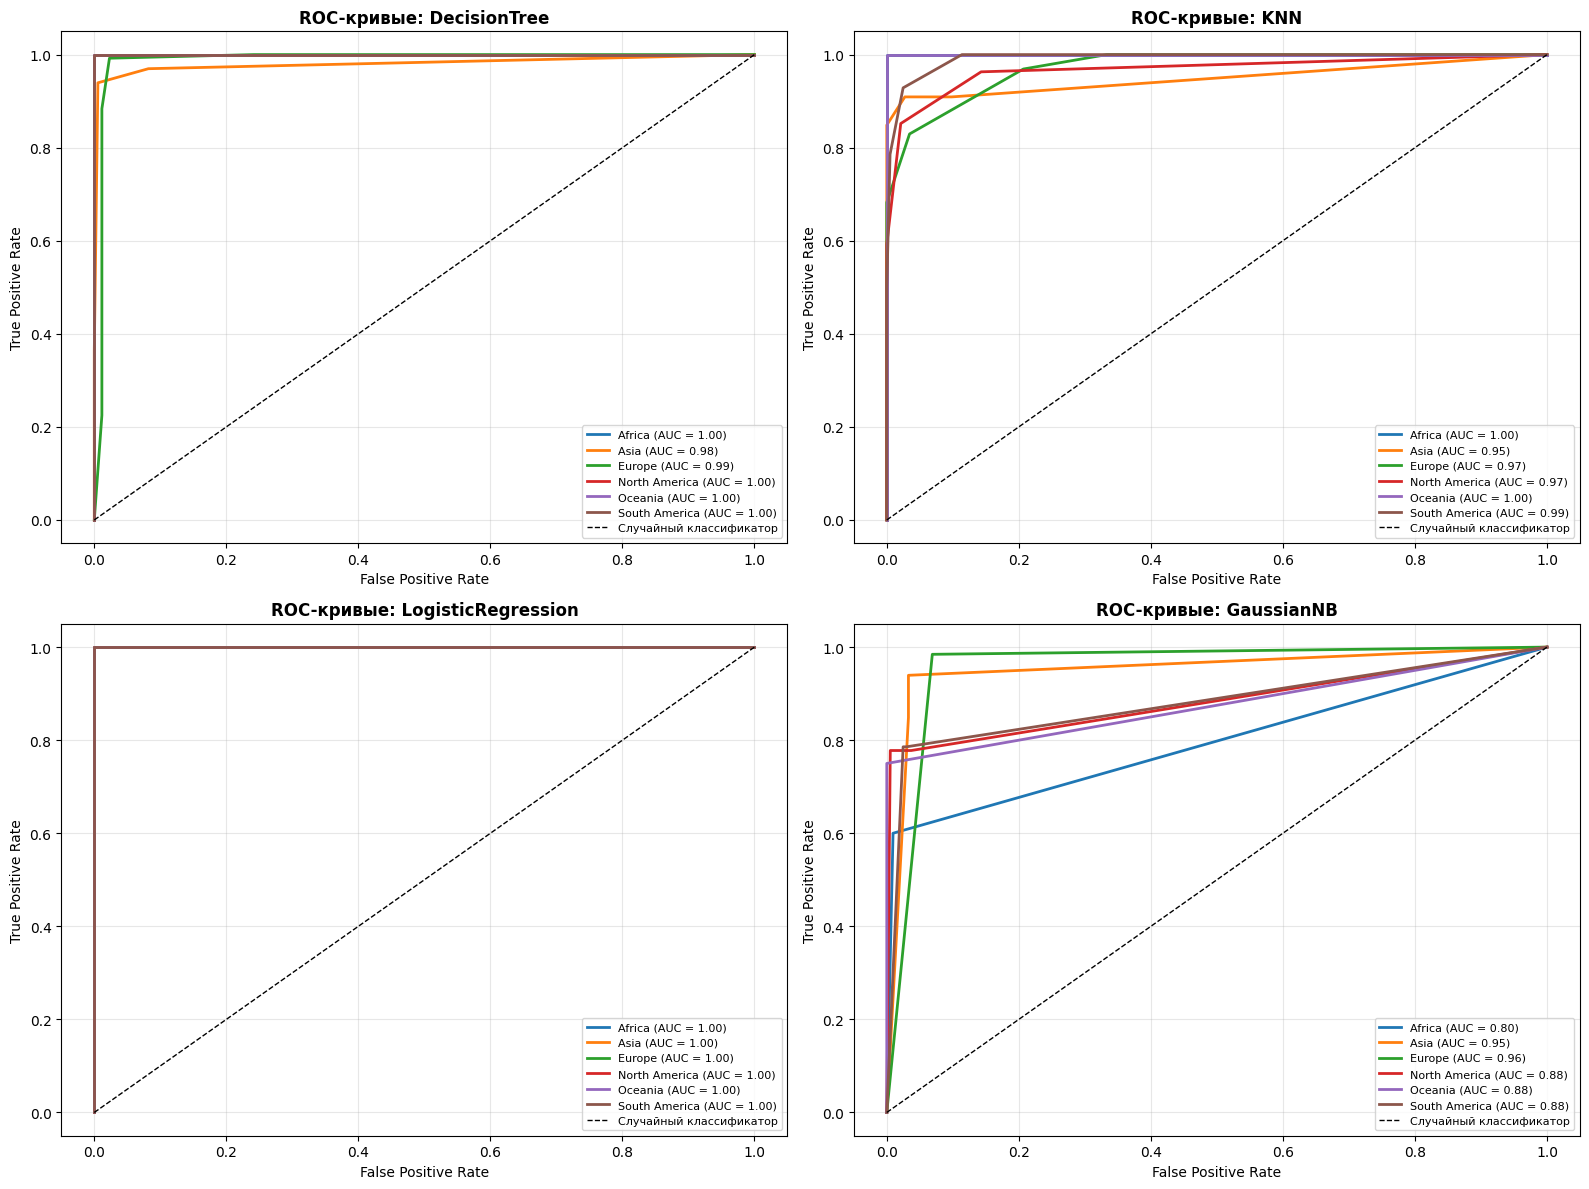

In [85]:
models_with_proba = {}
for name, model in models_dict.items():
    if hasattr(model, 'predict_proba'):
        models_with_proba[name] = model

if len(models_with_proba) > 0:
    le = LabelEncoder()
    y_test_encoded = le.fit_transform(y_test)
    classes_encoded = le.transform(classes)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()

    for idx, (name, model) in enumerate(models_with_proba.items()):
        if idx >= 4:
            break

        y_proba = model.predict_proba(X_test_scaled)

        for i, class_label in enumerate(classes):
            y_binary = (y_test_encoded == classes_encoded[i]).astype(int)
            if len(np.unique(y_binary)) > 1:
                fpr, tpr, _ = roc_curve(y_binary, y_proba[:, i])
                roc_auc = auc(fpr, tpr)
                axes[idx].plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})', linewidth=2)

        axes[idx].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Случайный классификатор')
        axes[idx].set_xlabel('False Positive Rate', fontsize=10)
        axes[idx].set_ylabel('True Positive Rate', fontsize=10)
        axes[idx].set_title(f'ROC-кривые: {name}', fontsize=12, fontweight='bold')
        axes[idx].legend(loc='lower right', fontsize=8)
        axes[idx].grid(alpha=0.3)

    for idx in range(len(models_with_proba), 4):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Нет моделей с поддержкой predict_proba для построения ROC-кривых.")

# Итоговая сводка

In [86]:

print(f"Лучшая модель по Accuracy: {results_df.iloc[0]['model']}")
print(f"Accuracy лучшей модели: {results_df.iloc[0]['Accuracy']:.4f}")
print(f"F1-мера лучшей модели: {results_df.iloc[0]['F1']:.4f}")
print("\nВсе модели отсортированы по убыванию Accuracy:")
print(results_df[['model', 'Accuracy', 'Precision', 'Recall', 'F1']].to_string(index=False))

Лучшая модель по Accuracy: DecisionTree
Accuracy лучшей модели: 0.9861
F1-мера лучшей модели: 0.9860

Все модели отсортированы по убыванию Accuracy:
             model  Accuracy  Precision   Recall       F1
      DecisionTree  0.986111   0.986038 0.986111 0.986031
LogisticRegression  0.986111   0.986427 0.986111 0.985860
        GaussianNB  0.907407   0.910901 0.907407 0.906990
               KNN  0.888889   0.897280 0.888889 0.884529
